In [156]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import bic

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

bool

In [176]:
class ValutationTool:
    '''Tool that based on sklearn Boston dataset.
    It calculate home price using input parameters.
    
    Parameters
    ----------
    CRIM    :  per capita crime rate by town
    ZN      :  proportion of residential land zoned for lots over 25,000 sq.ft.
    CHAS    :  Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    NOX     :  nitric oxides concentration (parts per 10 million)
    RM      :  average number of rooms per dwelling
    DIS     :  weighted distances to five Boston employment centres
    RAD     :  index of accessibility to radial highways
    TAX     :  full-value property-tax rate per $10,000
    PTRATIO :  pupil-teacher ratio by town
    B       :  1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT   :  % lower status of the population
    high_confidence  :  True - 95% confidence that right price in range(range bigger), False - 68% confidence that right price in range(range smaller)
    '''
    def __init__(self):
        boston_dataset = load_boston()
        data = pd.DataFrame(data=boston_dataset.data, columns=boston_dataset.feature_names)
        log_prices = np.log(boston_dataset.target)

        MEDIAN = 775 # This value was taken from www.realtor.com (as of January 2022)

        self.coef = MEDIAN/np.median(boston_dataset.target) # To get closer to the home price in 2022
        self._features = data.drop(['INDUS', 'AGE'], axis=1) # p-value showed that 'INDUS' and 'AGE' are less significant
        self._get_index = features.columns.get_indexer
        self._target = pd.DataFrame(log_prices, columns=['PRICE'])
        self._property_stats = features.mean().values.reshape(1,11) # if user doesn't enter some feature, it can be taken as an average
        self._regr = LinearRegression().fit(self._features, self._target)
        self._fitted_vals = self._regr.predict(self._features)
        self._rmse = mean_squared_error(self._target, self._fitted_vals, squared=False) # to calculate range of prices
        
    def validation(self, dict_data, high_confidence):
        if dict_data['RM'] < 1:
            return 'Error: RM does not have value less 1'
        
        if dict_data['CHAS'] not in [0,1]:
            return 'Error: CHAS accepts only 0 or 1'
        
        if type(high_confidence) != bool:
            return 'Error: high_confidence accepts only boolean value'
        
        return True
    
    def get_estimate(self, CRIM=None, ZN=None, CHAS=False, NOX=None, RM=None, DIS=None,
                     RAD=None, TAX=None, PTRATIO=None, B=None, LSTAT=None, high_confidence=False):
        
        dict_data = {str(k): v for k,v in zip(self._features.columns, [CRIM, ZN, CHAS, NOX, RM, DIS,
                     RAD, TAX, PTRATIO, B, LSTAT])}
        
        for k,v in dict_data.items():
            if v == None:
                dict_data[k] = float(self._property_stats[0][self._get_index([k])])
        is_nerror = self.validation(dict_data, high_confidence)
        if is_nerror != True:
            print(is_nerror)
            return
        features_frame = pd.DataFrame([dict_data])
        if high_confidence: # If True: using 2*standart deviation, FalseL usign 1*standart deviation
            upper_bound = np.e**(self._regr.predict(features_frame)[0][0] + 2*self._rmse)
            lower_bound = np.e**(self._regr.predict(features_frame)[0][0] - 2*self._rmse)
        else:
            upper_bound = np.e**(self._regr.predict(features_frame)[0][0] + self._rmse) # upper bound of range
            lower_bound = np.e**(self._regr.predict(features_frame)[0][0] - self._rmse) # lower bound of range
        

        return (np.around(((np.e**(self._regr.predict(features_frame))[0][0]) * self.coef * 1000), -3), 
                np.around((upper_bound * self.coef * 1000), -3), np.around((lower_bound * self.coef * 1000), -3))
        
        
val = ValutationTool()

price = val.get_estimate(RM=2, CHAS=1)
print(f'Estimate price: {price[0]}$\nRange: [{price[1]}; {price[2]}]$')

# Testing

data = dict()
data['RM'] = 0 
data['CHAS'] = 2
high_confidence = 0 
assert val.validation(data, high_confidence) == 'Error: RM does not have value less 1'
data['RM'] = 1
assert val.validation(data, high_confidence) == 'Error: CHAS accepts only 0 or 1'
data['CHAS'] = 0
assert val.validation(data, high_confidence) == 'Error: high_confidence accepts only boolean value'

Estimate price: 568000.0$
Range: [686000.0; 471000.0]$


In [93]:
# Gather Data
boston_dataset = load_boston()
data = pd.DataFrame(data=boston_dataset.data, columns=boston_dataset.feature_names)
features = data.drop(['INDUS', 'AGE'], axis=1)

log_prices = np.log(boston_dataset.target)
src_target = boston_dataset.target
target = pd.DataFrame(log_prices, columns=['PRICE'])

tar = boston_dataset.target

# plt.hist(boston_dataset.target)
# plt.show()
# plt.hist(log_prices)
# plt.show()
# plt.hist(np.e**log_prices)
# plt.show()

## Why did i do a data log transformation?

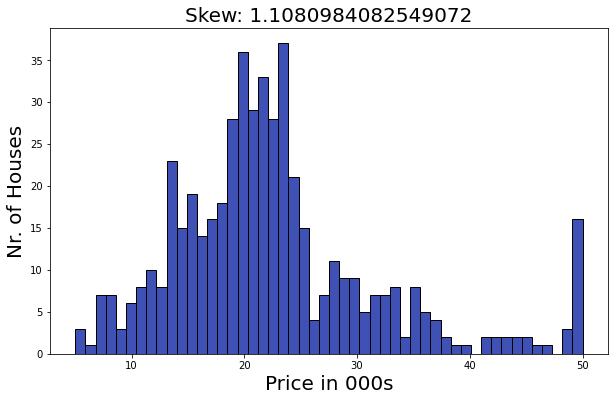

In [94]:
plt.figure(figsize=(10, 6))
plt.hist(src_target, bins=50, ec='black', color='#3F51B5')
plt.xlabel('Price in 000s', fontsize=20)
plt.ylabel('Nr. of Houses', fontsize=20)
df_target = pd.DataFrame(data=src_target, columns=['PRICE'])
plt.title(f'Skew: {df_target["PRICE"].skew()}', fontsize=20)
plt.show()

# We can see that on the lower right corner is outlier,
# And our prices has approximately normal distribution.

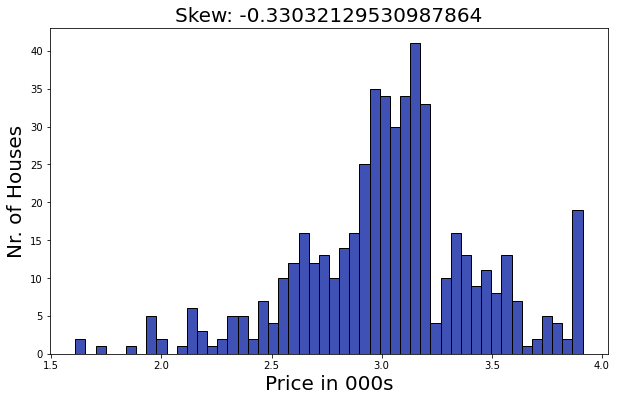

In [95]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(src_target), bins=50, ec='black', color='#3F51B5')
plt.xlabel('Price in 000s', fontsize=20)
plt.ylabel('Nr. of Houses', fontsize=20)
df_log_target = pd.DataFrame(data=src_target, columns=['PRICE'])
df_log_target = pd.DataFrame(data=np.log(src_target), columns=['PRICE'])
plt.title(f'Skew: {df_log_target["PRICE"].skew()}', fontsize=20)
plt.show()

# There's skew closer to zero than it was before log transformation

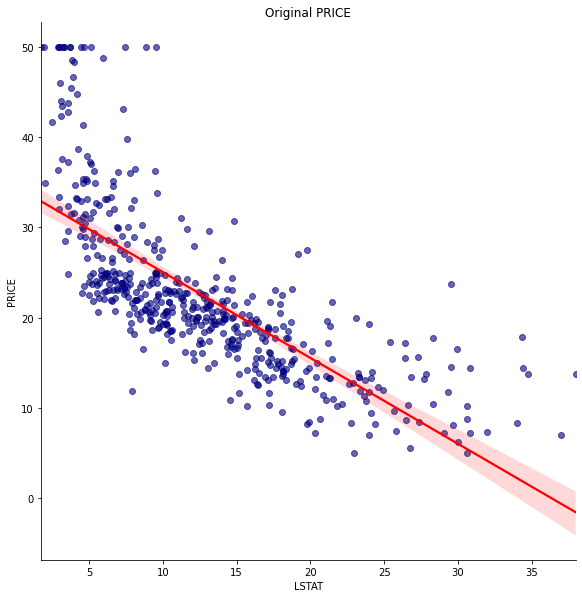

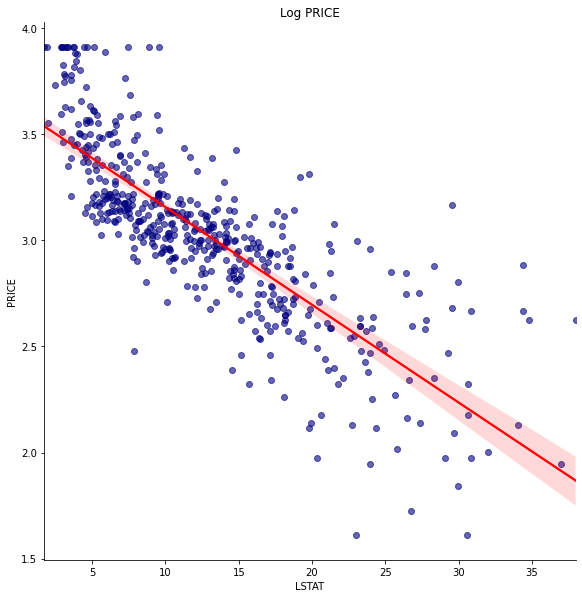

In [96]:
# Compare log and original prices using linear regression

sns.lmplot(y='PRICE', x='LSTAT', height=8, data=pd.DataFrame({'PRICE': df_target['PRICE'], 'LSTAT': data['LSTAT']}),
                                                             scatter_kws={'alpha': 0.6, 'color': 'navy'}, line_kws={'color': 'red'})
plt.title('Original PRICE')
sns.lmplot(y='PRICE', x='LSTAT', height=8, data=pd.DataFrame({'PRICE': df_log_target['PRICE'], 'LSTAT': data['LSTAT']}),
                                                            scatter_kws={'alpha': 0.6, 'color': 'navy'}, line_kws={'color': 'red'})
plt.title('Log PRICE')
plt.show()

## Why did i drop 'INDUS' and 'AGE' features?

In [97]:
# p-values
data_const = sm.add_constant(data)
model = sm.OLS(df_target, data_const)
res = model.fit()

pd.DataFrame({'coef': res.params, 'p-value': round(res.pvalues, 3)})

,coef,p-value
const,36.459488,0.000
CRIM,-0.108011,0.001
ZN,0.046420,0.001
INDUS,0.020559,0.738
CHAS,2.686734,0.002
NOX,-17.766611,0.000
RM,3.809865,0.000
AGE,0.000692,0.958
DIS,-1.475567,0.000
RAD,0.306049,0.000


In [98]:
data_const = sm.add_constant(data)
model = sm.OLS(df_log_target, data_const)
res = model.fit()

pd.DataFrame({'coef': res.params, 'p-value': round(res.pvalues, 3)})

,coef,p-value
const,4.102042,0.000
CRIM,-0.010272,0.000
ZN,0.001172,0.033
INDUS,0.002467,0.317
CHAS,0.100888,0.004
NOX,-0.778399,0.000
RM,0.090833,0.000
AGE,0.000211,0.691
DIS,-0.049087,0.000
RAD,0.014267,0.000


### It can be seen that p-value shows high value of 'INDUS' and 'AGE' for both kinds of prices. It indicates that this features has less significant.
### Using Bayesian Information Criterion(BIC) decide which model is better.

In [99]:
data_const = sm.add_constant(data)
model = sm.OLS(df_target, data_const)
res = model.fit()
print(f'Original\n')
print(f'BIC: {res.bic}\nR-squared: {res.rsquared}\n{30*"-"}\n')

data_const = sm.add_constant(data)
model = sm.OLS(df_log_target, data_const)
res = model.fit()
print(f'Log\n')
print(f'BIC: {res.bic}\nR-squared: {res.rsquared}\n{30*"-"}\n')

data_const = sm.add_constant(data)
model = sm.OLS(df_log_target, data_const.drop(['INDUS', 'AGE'], axis=1))
res = model.fit()
print(f'Log & Excluding INDUS and AGE\n')
print(f'BIC: {res.bic}\nR-squared: {res.rsquared}')

Original

BIC: 3084.7801074455724
R-squared: 0.7406426641094095
------------------------------

Log

BIC: -172.056932905522
R-squared: 0.7896407327934389
------------------------------

Log & Excluding INDUS and AGE

BIC: -183.31441955542385
R-squared: 0.7891431041340249
